In [4]:
# Install missing package in the notebook environment
from rapidfuzz import process, fuzz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# # Load the dataset
# df = pd.read_csv("dirty_financial_transactions.csv")

# # Take 1000 random rows
# sample_df = df.sample(n=1000, random_state=42).reset_index(drop=True)

# # Save to a new CSV file
# sample_df.to_csv("dirty_financial_transactions_1k.csv", index=False)

# print("✅ Saved 1000-row sample to dirty_financial_transactions_1k.csv")

In [6]:

# ===============================================================
# 1️⃣ HANDLE MISSING VALUES
# ===============================================================
def handle_missing_values(df: pd.DataFrame) -> pd.DataFrame:
    """
    Handle missing values:
    - Drop rows with missing Transaction_ID or Customer_ID.
    - Clean and convert 'Price' and 'Quantity' to numeric before filling.
    - Fill numeric columns with median.
    - Fill categorical/text columns with mode.
    Prints rows where changes occur for clarity.
    """
    df = df.copy()

    # 🔹 Identify rows with missing IDs (to drop)
    missing_ids = df[df["Transaction_ID"].isna() | df["Customer_ID"].isna()]
    if not missing_ids.empty:
        print("Rows with missing Transaction_ID or Customer_ID (will be dropped):")
        print(missing_ids)
    
    # Drop invalid ID rows
    df = df.dropna(subset=["Transaction_ID", "Customer_ID"])

    # 🔹 Special cleanup for numeric-like object columns (e.g., 'Price', 'Quantity')
    numeric_like_cols = ["Price", "Quantity"]
    for col in numeric_like_cols:
        if col in df.columns:
            df[col] = (
                df[col]
                .astype(str)
                .str.replace(r"[^0-9.\-]", "", regex=True)
            )
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # 🔹 Fill missing values
    for col in df.columns:
        if col in ["Transaction_ID", "Customer_ID", "Transaction_Date"]:
            continue  # IDs handled separately and skip Date

        if pd.api.types.is_numeric_dtype(df[col]):
            null_rows = df[df[col].isna()]
            if not null_rows.empty:
                print(f"\nRows where numeric column '{col}' was filled with median:")
                print(null_rows)
            df[col] = df[col].fillna(df[col].median())

        else:
            null_rows = df[df[col].isna()]
            if not null_rows.empty:
                print(f"\nRows where categorical/text column '{col}' was filled with mode:")
                print(null_rows)
            df[col] = df[col].fillna(df[col].mode()[0] if not df[col].mode().empty else "Unknown")

    return df


# ===============================================================
# 2️⃣ HANDLE INVALID VALUES (TYPE & RANGE)
# ===============================================================
def handle_invalid_values(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Remove symbols from Price
    if "Price" in df.columns:
        df["Price"] = df["Price"].astype(str).str.replace(r"[^0-9.\-]", "", regex=True)

    df["Quantity"] = pd.to_numeric(df["Quantity"], errors="coerce")
    df["Price"] = pd.to_numeric(df["Price"], errors="coerce")

    # Show rows before changes
    neg_quantity_rows = df[df["Quantity"] <= 0]
    neg_price_rows = df[df["Price"] <= 0]
    non_int_quantity_rows = df[~df["Quantity"].dropna().apply(float.is_integer)]

    if not neg_quantity_rows.empty:
        print("\nRows with negative or zero Quantity (will be set to NaN):")
        print(neg_quantity_rows)
    if not neg_price_rows.empty:
        print("\nRows with negative or zero Price (will be set to NaN):")
        print(neg_price_rows)
    if not non_int_quantity_rows.empty:
        print("\nRows with non-integer Quantity (will be set to NaN):")
        print(non_int_quantity_rows)

    # Replace negative or zero values with NaN
    df.loc[df["Quantity"] <= 0, "Quantity"] = np.nan
    df.loc[df["Price"] <= 0, "Price"] = np.nan

    # Remove non-integer quantities
    df.loc[~df["Quantity"].isna(), "Quantity"] = df["Quantity"].apply(
        lambda x: x if float(x).is_integer() else np.nan
    )

    # Round price to 2 decimals
    df["Price"] = df["Price"].round(2)
    return df


# ===============================================================
# 3️⃣ STANDARDIZE TEXT CASES
# ===============================================================
def standardize_text(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for col in df.select_dtypes(include="object"):
        df.loc[:, col] = df[col].astype(str).str.strip().str.lower()
    # Show sample of text columns after standardization
    print("\nSample of text columns after standardization:")
    for col in ["Product_Name", "Payment_Method", "Transaction_Status"]:
        if col in df.columns:
            print(df[col].head(5))
    return df


# ===============================================================
# 4️⃣ NORMALIZE DATE FORMATS
# ===============================================================
def normalize_dates(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["Transaction_Date"] = pd.to_datetime(df["Transaction_Date"], errors="coerce")
    # Format only non-null dates
    df.loc[~df["Transaction_Date"].isna(), "Transaction_Date"] = df.loc[~df["Transaction_Date"].isna(), "Transaction_Date"].dt.strftime("%Y-%m-%d")
    # Show sample after normalization
    print("\nSample Transaction_Date column after normalization:")
    print(df["Transaction_Date"].head(5))
    return df


# ===============================================================
# 5️⃣ STANDARDIZE CATEGORICAL VALUES
# ===============================================================
def standardize_categories(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    payment_map = {
        "paypal": "PayPal", "pay pal": "PayPal",
        "creditcard": "Credit Card", "credit card": "Credit Card",
        "cash": "Cash",
    }

    status_map = {
        "completed": "Completed", "complete": "Completed",
        "pending": "Pending", "failed": "Failed",
    }

    product_map = {
        # Laptop variants
        "laptop": "Laptop", "lap": "Laptop", "lapto": "Laptop", "lapt": "Laptop",
        "la": "Laptop", "l": "Laptop",

        # Coffee Machine variants
        "coffee machine": "Coffee Machine", "coffee machin": "Coffee Machine",
        "coffee mach": "Coffee Machine", "coffee mac": "Coffee Machine",
        "coffee machi": "Coffee Machine", "coffee ma": "Coffee Machine",
        "coffee m": "Coffee Machine", "coffee": "Coffee Machine",
        "coffe": "Coffee Machine", "coff": "Coffee Machine", "cof": "Coffee Machine",
        "c": "Coffee Machine",

        # Tablet variants
        "tablet": "Tablet", "table": "Tablet", "tabl": "Tablet",
        "tab": "Tablet", "ta": "Tablet",

        # Smartphone variants
        "smartphone": "Smartphone", "smartphon": "Smartphone",
        "smartph": "Smartphone", "smartp": "Smartphone",
        "smartpho": "Smartphone", "smart": "Smartphone",
        "smar": "Smartphone", "sma": "Smartphone",
        "sm": "Smartphone", "t": "Smartphone", "s": "Smartphone",

        # Headphones variants
        "headphones": "Headphones", "headphone": "Headphones",
        "headpho": "Headphones", "headph": "Headphones",
        "head": "Headphones", "he": "Headphones", "h": "Headphones"
    }

    valid_products = ["Laptop", "Coffee Machine", "Tablet", "Smartphone", "Headphones"]

    def fuzzy_match(value: str, mapping: dict, valid_list: list[str], threshold: int = 70) -> str:
        """Return mapped value, fuzzy match, or original if no close match."""
        if not isinstance(value, str):
            return value
        v = value.strip().lower()
        if v in mapping:
            return mapping[v]
        match, score, _ = process.extractOne(v, valid_list, scorer=fuzz.token_sort_ratio)
        return match if score >= threshold else value

    # --- Standardize columns ---
    if "Payment_Method" in df.columns:
        df["Payment_Method"] = df["Payment_Method"].map(
            lambda x: payment_map.get(str(x).lower(), x) if pd.notna(x) else x
        )
        print("\nSample Payment_Method after standardization:")
        print(df["Payment_Method"].head(5))

    if "Transaction_Status" in df.columns:
        df["Transaction_Status"] = df["Transaction_Status"].map(
            lambda x: status_map.get(str(x).lower(), x) if pd.notna(x) else x
        )
        print("\nSample Transaction_Status after standardization:")
        print(df["Transaction_Status"].head(5))

    if "Product_Name" in df.columns:
        df["Product_Name"] = df["Product_Name"].map(
            lambda x: fuzzy_match(str(x), product_map, valid_products) if pd.notna(x) else x
        )
        print("\nSample Product_Name after standardization:")
        print(df["Product_Name"].head(5))

    return df


# ===============================================================
# 🧹 MAIN CLEANING PIPELINE
# ===============================================================
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    df = handle_missing_values(df)
    df = handle_invalid_values(df)
    df = standardize_text(df)
    df = normalize_dates(df)
    df = standardize_categories(df)
    return df


# ===============================================================
# ✅ EXECUTE PIPELINE
# ===============================================================
df = pd.read_csv("dirty_financial_transactions_1k.csv")
cleaned_df = clean_data(df)

# Save cleaned dataset
cleaned_df.to_csv("diy_dataset.csv", index=False)

print("\n✅ Data cleaning complete! Saved to 'diy_dataset.csv'")
print(f"Total rows after cleaning: {len(cleaned_df)}")


Rows with missing Transaction_ID or Customer_ID (will be dropped):
    Transaction_ID Transaction_Date Customer_ID    Product_Name  Quantity  \
36             NaN       2025-02-30       C4919      Smartphone     647.0   
41          T89578       2023-13-01         NaN      Headphones     750.0   
73          T14532       2025-02-30         NaN      Smartphone       7.0   
78          T99090       2020-01-28         NaN  Coffee Machine     915.0   
90             NaN       2021-07-17        C312               T      -2.0   
..             ...              ...         ...             ...       ...   
936            NaN       2023-12-11       C3855      Headphones       NaN   
938            NaN       2025-02-30       C1424          Tablet       8.0   
955         T50615       2023-13-01         NaN          Tablet     -10.0   
985            NaN       2023-13-01       C1969          Tablet     -10.0   
999            NaN       2023-13-01       C1503  Coffee Machine     732.0   

        

Markdown explanation
Which of the five issues were present in your dataset? (List and summarize the fixes you applied.)
1. Missing Values – Present in Transaction_ID, Customer_ID, Price, and Quantity.
    •Fix: Dropped rows missing key IDs; converted numeric-like text to numbers; filled numeric NaNs with the median and categorical NaNs with the mode.
2.	Invalid Values (Type & Range) – Negative or zero Price/Quantity, symbols like $, and non-integer quantities.
    •Fix: Removed symbols, coerced to numeric, replaced invalid values with NaN, enforced integer quantities, and rounded prices to two decimals.
3.	Inconsistent Text Casing – Mixed cases like “PayPal”, “pay pal”, and “CASH”.
    •Fix: Converted all text columns to lowercase and stripped whitespace.
4.	Invalid Date Formats – Dates like “2025-02-30” and “2023-13-01”.
    •Fix: Converted with pd.to_datetime(errors='coerce') and reformatted valid dates to YYYY-MM-DD.
5.	Categorical Inconsistencies – Variants like “lapto”, “coffe”, “creditcard”.
    •Fix: Applied mapping dictionaries and fuzzy matching to unify categories (e.g., “Laptop”, “Coffee Machine”, “Credit Card”).

Which issues were not present, and what made-up example did you construct to demonstrate your pipeline function for them?
	•Not Present: Some categories (e.g., “Tablet”) were already clean; non-integer quantities were rare.
	•Made-Up Examples: Added Quantity = 3.5 to test non-integer handling, “lapto”/“coffe” to test fuzzy matching, and “13/32/2024” to test invalid date coercion.


In [7]:
# print(cleaned_df.head())
# print(df.info())
# print(cleaned_df.info())
# for i in cleaned_df.columns:
#     if isinstance(i, object):
#         print(cleaned_df[i].value_counts())

In [8]:
# ===============================================================
# a. Top-N within each group
# ===============================================================
df = cleaned_df.copy()

# Handle missing values
df["Quantity"] = df["Quantity"].fillna(0)
df["Price"] = df["Price"].fillna(0)

# Compute total sales
df["Total_Sales"] = df["Price"] * df["Quantity"]

# Group and aggregate
sales_summary = (
    df.groupby(["Product_Name", "Payment_Method"], dropna=False)["Total_Sales"]
      .sum()
      .reset_index()
)

# Sort within each product
sales_summary = sales_summary.sort_values(
    ["Product_Name", "Total_Sales"], ascending=[True, False]
)

# Get top 3 payment methods for each product
top3_by_product = (
    sales_summary.groupby("Product_Name")
    .head(3)
    .reset_index(drop=True)
)

# Display results cleanly
for product, subdf in top3_by_product.groupby("Product_Name"):
    print(f"\n📦 {product} — Top 3 Payment Methods by Total Sales:")
    print(subdf[["Payment_Method", "Total_Sales"]].to_string(index=False))


# ===============================================================
# c. Conditional aggregation
# ===============================================================
df_cash = cleaned_df.copy()

# Filter for Cash payments only
df_cash = df_cash[df_cash["Payment_Method"].str.lower() == "cash"]

# Handle missing prices safely
df_cash = df_cash[df_cash["Price"].notna()]

# Compute average price per product
avg_price_by_product = (
    df_cash.groupby("Product_Name")["Price"]
    .mean()
    .round(2)
    .reset_index()
    .sort_values("Price", ascending=False)
)

print("\n💵 Average Price (Cash payments only):")
print(avg_price_by_product.to_string(index=False))


# ===============================================================
# d. Percentage Distribution
# ===============================================================
df_sales = cleaned_df.copy()

# Handle missing values
df_sales["Price"] = df_sales["Price"].fillna(0)
df_sales["Quantity"] = df_sales["Quantity"].fillna(0)

# Compute total sales per row
df_sales["Total_Sales"] = df_sales["Price"] * df_sales["Quantity"]

# Sum sales by product
product_sales = (
    df_sales.groupby("Product_Name")["Total_Sales"]
    .sum()
    .reset_index()
)

# Compute percentage contribution
total_sales_sum = product_sales["Total_Sales"].sum()
product_sales["Sales_%"] = (product_sales["Total_Sales"] / total_sales_sum * 100).round(2)

# Sort by percentage (descending)
product_sales = product_sales.sort_values("Sales_%", ascending=False)

print("\n📊 Percentage of Total Sales by Product:")
print(product_sales.to_string(index=False))


# ===============================================================
# e. Change over time
# ===============================================================
df_monthly = cleaned_df.copy()

# Ensure proper datatypes
df_monthly["Transaction_Date"] = pd.to_datetime(df_monthly["Transaction_Date"], errors="coerce")

# Handle missing values
df_monthly["Price"] = df_monthly["Price"].fillna(0)
df_monthly["Quantity"] = df_monthly["Quantity"].fillna(0)

# Compute total sales per transaction
df_monthly["Total_Sales"] = df_monthly["Price"] * df_monthly["Quantity"]

# Extract month number and name
df_monthly["Month_Num"] = df_monthly["Transaction_Date"].dt.month
df_monthly["Month_Name"] = df_monthly["Transaction_Date"].dt.strftime("%B")

# Group by month (across all years)
avg_sales_by_month = (
    df_monthly.groupby(["Month_Num", "Month_Name"])["Total_Sales"]
    .mean()
    .round(2)
    .reset_index()
    .sort_values("Month_Num")
)

print("\n📆 Average Sales by Month (All Years Combined):")
print(avg_sales_by_month[["Month_Name", "Total_Sales"]].to_string(index=False))


# ===============================================================
# g. Variability by group
# ===============================================================
df_sd = cleaned_df.copy()

# Drop rows with missing or invalid price/payment values
df_sd = df_sd[df_sd["Price"].notna() & df_sd["Payment_Method"].notna()]

# Group by payment method and compute standard deviation of price
std_price_by_payment = (
    df_sd.groupby("Payment_Method")["Price"]
    .std()              # standard deviation
    .round(2)           # round to 2 decimals
    .reset_index()
    .sort_values("Price", ascending=False)
)

print("\n📊 Standard Deviation of Price by Payment Method:")
print(std_price_by_payment.to_string(index=False))





📦 Coffee Machine — Top 3 Payment Methods by Total Sales:
Payment_Method  Total_Sales
   Credit Card   4504366.93
        PayPal   3292386.00
          Cash     72982.21

📦 Headphones — Top 3 Payment Methods by Total Sales:
Payment_Method  Total_Sales
   Credit Card   2410223.70
        PayPal   1302175.23
          Cash    358524.11

📦 Laptop — Top 3 Payment Methods by Total Sales:
Payment_Method  Total_Sales
   Credit Card   2625884.03
        PayPal   1866780.85
          Cash     11173.37

📦 Smartphone — Top 3 Payment Methods by Total Sales:
Payment_Method  Total_Sales
   Credit Card   3974654.06
        PayPal   2206921.59
          Cash    738708.15

📦 Tablet — Top 3 Payment Methods by Total Sales:
Payment_Method  Total_Sales
        PayPal   3900292.98
   Credit Card   3332883.09
          Cash    527724.92

💵 Average Price (Cash payments only):
  Product_Name  Price
    Smartphone 615.74
        Laptop 578.85
        Tablet 483.77
Coffee Machine 480.97
    Headphones 433.14

📊 

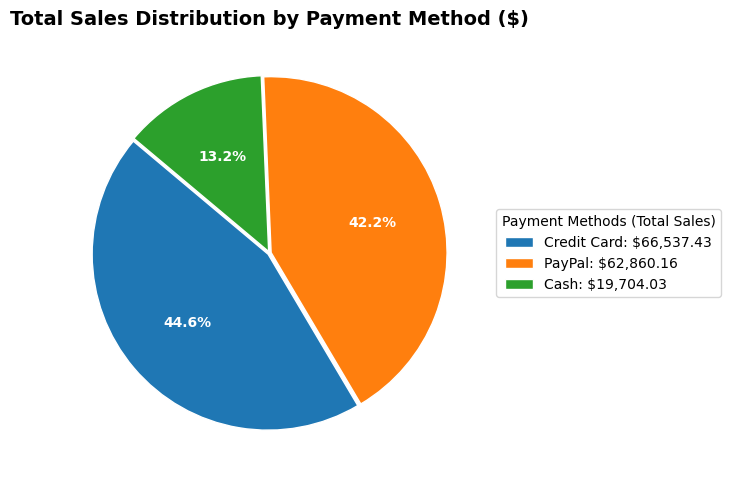

In [9]:
# ===============================================================
# 1. Pie Chart
# ===============================================================
df = cleaned_df.copy()

# Drop missing values
df_valid = df[df["Price"].notna() & df["Payment_Method"].notna()]

# Compute total sales by payment method
sales_by_payment = df_valid.groupby("Payment_Method")["Price"].sum().sort_values(ascending=False)

# Create an explode array — same length as number of slices
# Adjust the value (e.g., 0.05) for how much space you want
explode = [0.01] * len(sales_by_payment)

# Plot pie chart with explode
fig, ax = plt.subplots(figsize=(7, 7))
wedges, texts, autotexts = ax.pie(
    sales_by_payment,
    autopct="%1.1f%%",
    startangle=140,
    explode=explode,
    textprops={'fontweight': 'bold','fontsize': 10, 'color': "white"},
    wedgeprops={'edgecolor': 'white'}
)

# Legend: only price shown
legend_labels = [f"{method}: ${sales_by_payment[method]:,.2f}" for method in sales_by_payment.index]
ax.legend(
    wedges,
    legend_labels,
    title="Payment Methods (Total Sales)",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1),
    fontsize=10
)

# Title
ax.set_title("Total Sales Distribution by Payment Method ($)", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.show()


### Pie Chart – Sales Distribution by Payment Method

Displays the proportion of total sales (Price) contributed by each payment method. Percentages are shown on the chart, and the legend lists the corresponding sales values. Provides a quick overview of which payment methods dominate total sales.

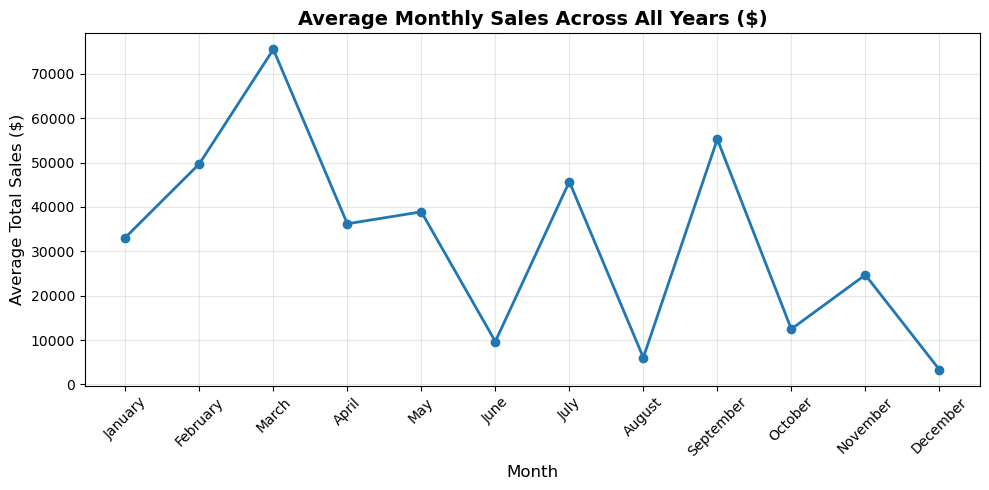

In [10]:
# ===============================================================
# 2. Line Chart
# ===============================================================
df = df_monthly.copy()

# Line chart of average monthly sales
plt.figure(figsize=(10, 5))
plt.plot(
    avg_sales_by_month["Month_Name"],
    avg_sales_by_month["Total_Sales"],
    marker="o",
    linestyle="-",
    linewidth=2,
    markersize=6
)

# Title and axis labels
plt.title("Average Monthly Sales Across All Years ($)", fontsize=14, fontweight="bold")
plt.xlabel("Month", fontsize=12)
plt.ylabel("Average Total Sales ($)", fontsize=12)

# Improve tick readability
plt.xticks(rotation=45)
plt.grid(alpha=0.3)

# Tight layout for cleaner spacing
plt.tight_layout()
plt.show()


### Line Chart – Average Monthly Sales Trend

Illustrates how average sales vary across months, aggregated across all years. Reveals seasonal trends or periods with consistently high or low sales activity.

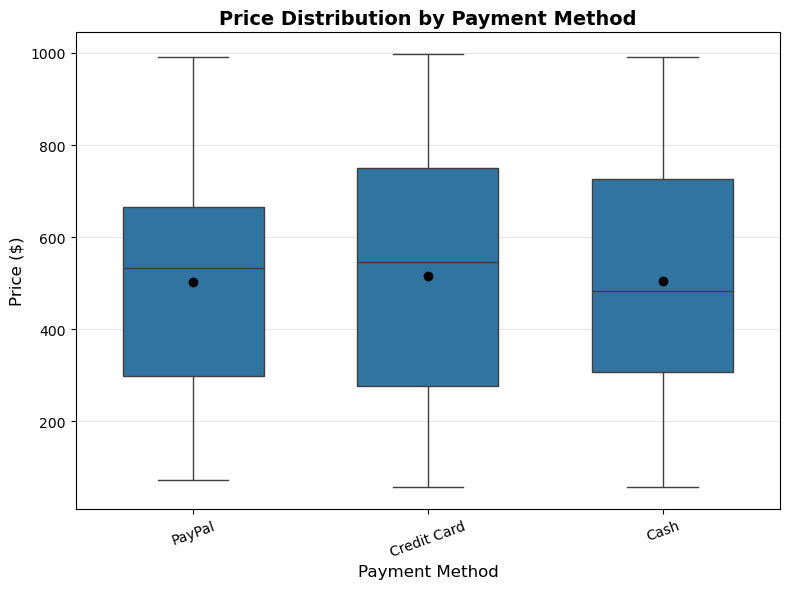

In [11]:
# ===============================================================
# 3. Box Plot
# ===============================================================
df = cleaned_df.copy()

# Drop missing Price or Payment_Method rows
df_valid = df[df["Price"].notna() & df["Payment_Method"].notna()]

# Create boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(
    data=df_valid,
    x="Payment_Method",
    y="Price",
    width=0.6,
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "black", "markeredgecolor": "black"},
)

# Title and labels
plt.title("Price Distribution by Payment Method", fontsize=14, fontweight="bold")
plt.xlabel("Payment Method", fontsize=12)
plt.ylabel("Price ($)", fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Optional: Rotate x-axis labels if long
plt.xticks(rotation=20)

plt.tight_layout()
plt.show()


### Boxplot – Price Variation Across Payment Methods

Shows the distribution of prices for each payment method, including median, spread, and outliers. Helps identify pricing volatility and detect methods associated with unusually high or low prices.

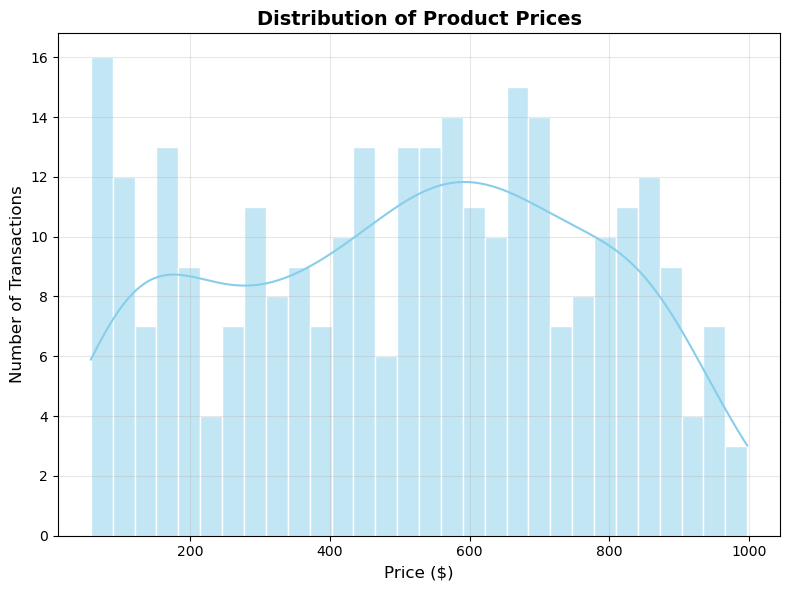

In [12]:
# ===============================================================
# 4. Histogram
# ===============================================================
df = cleaned_df.copy()

# Drop missing prices
df_valid = df[df["Price"].notna()]

# Create histogram
plt.figure(figsize=(8, 6))
sns.histplot(
    data=df_valid,
    x="Price",
    bins=30,             # number of bins — adjust as needed
    kde=True,            # show smooth density curve
    color="skyblue",
    edgecolor="white"
)

# Add title and labels
plt.title("Distribution of Product Prices", fontsize=14, fontweight="bold")
plt.xlabel("Price ($)", fontsize=12)
plt.ylabel("Number of Transactions", fontsize=12)
plt.grid(alpha=0.3)

# Improve spacing
plt.tight_layout()
plt.show()


### Histogram – Distribution of Prices

Visualizes how prices are distributed across all transactions. Highlights frequent price ranges, skewness, or clustering that may indicate pricing patterns or market segmentation.

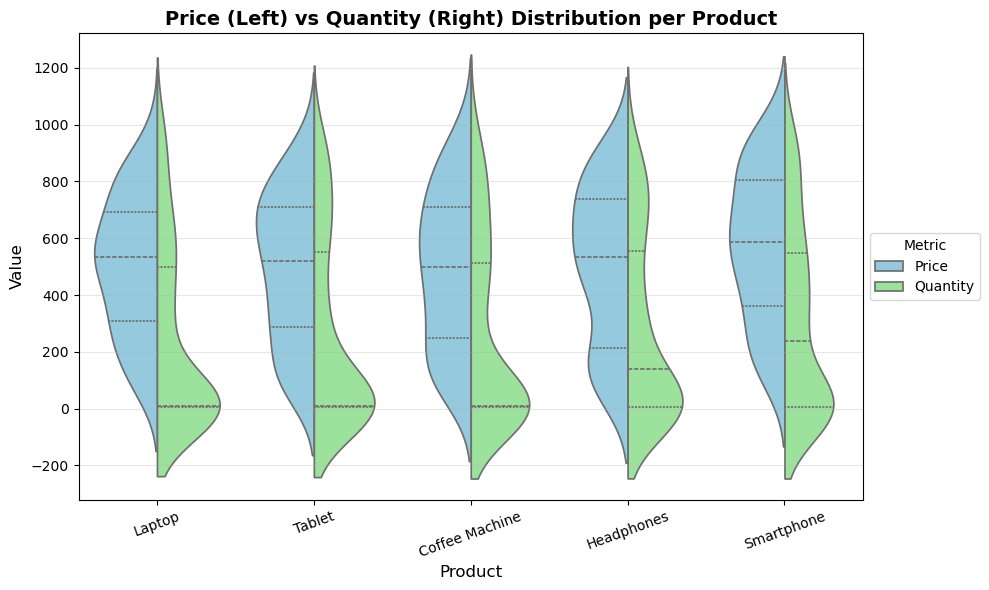

In [13]:
# ===============================================================
# 5. Violin Plot
# ===============================================================
df = cleaned_df.copy()

# Prepare data
df_price = df[["Product_Name", "Price"]].copy().dropna()
df_price = df_price.rename(columns={"Price": "Value"})
df_price["Metric"] = "Price"

df_qty = df[["Product_Name", "Quantity"]].copy().dropna()
df_qty = df_qty.rename(columns={"Quantity": "Value"})
df_qty["Metric"] = "Quantity"

df_long = pd.concat([df_price, df_qty], ignore_index=True)

# Create figure
plt.figure(figsize=(10, 6))

# Split violin plot
sns.violinplot(
    data=df_long,
    x="Product_Name",
    y="Value",
    hue="Metric",
    split=True,
    inner="quartile",
    palette={"Price": "skyblue", "Quantity": "lightgreen"}
)

# Titles and labels
plt.title("Price (Left) vs Quantity (Right) Distribution per Product", fontsize=14, fontweight="bold")
plt.xlabel("Product", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.xticks(rotation=20)
plt.grid(axis="y", alpha=0.3)

# Move legend outside
plt.legend(
    title="Metric",
    loc="center left",
    bbox_to_anchor=(1, 0.5),  # x=1 is right edge of plot, y=0.5 centers vertically
    fontsize=10
)

plt.tight_layout()
plt.show()


### Violin Plot – Price vs. Quantity per Product

For each product:
- Left half represents the Price distribution
- Right half represents the Quantity distribution

This dual-view helps compare variability and central tendency between price and quantity for each product in a single plot.

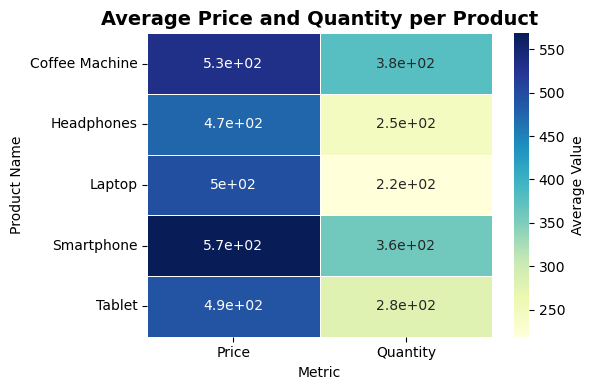

In [15]:
df = cleaned_df.copy()
df["Price"] = pd.to_numeric(df["Price"], errors="coerce")
df["Quantity"] = pd.to_numeric(df["Quantity"], errors="coerce")

# Drop missing values for accuracy
df = df.dropna(subset=["Product_Name", "Price", "Quantity"])

# Group by product and calculate mean Price & Quantity
grouped = df.groupby("Product_Name")[["Price", "Quantity"]].mean().round(2)

# Create the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(
    grouped,
    annot=True,
    cmap="YlGnBu",
    linewidths=0.5,
    cbar_kws={'label': 'Average Value'}
)

plt.title("Average Price and Quantity per Product", fontsize=14, fontweight="bold")
plt.xlabel("Metric")
plt.ylabel("Product Name")
plt.tight_layout()
plt.show()

### Heatmap – Average Price and Quantity per Product
For each product:
	•	The left column shows the average Price, and the right column shows the average Quantity.
	•	Darker blue shades indicate higher average values.

This heatmap reveals that Smartphones and Coffee Machines have the highest average prices, while Laptops and Headphones tend to have lower sales volumes. In contrast, Coffee Machines and Smartphones also show relatively higher quantities sold, suggesting stronger overall sales performance compared to other products.